/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

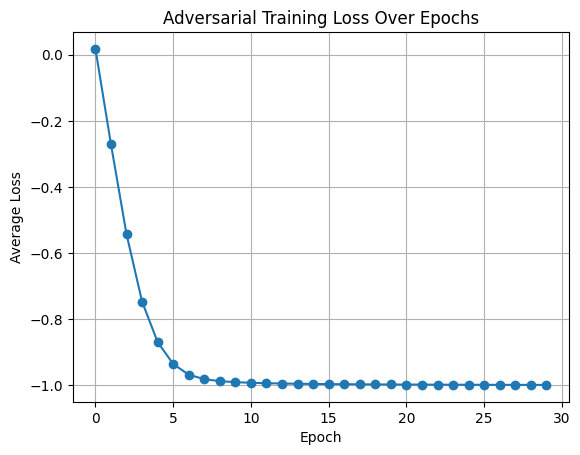

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
import random
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
encoder = AutoModel.from_pretrained(model_path)
encoder.to(device)

data_path = "/content/drive/MyDrive/data/malayalam_gender_profession_sentences.csv"
data = pd.read_csv(data_path)
data.rename(columns={
    'Male Sentence': 'male_sentence',
    'Female Sentence': 'female_sentence'
}, inplace=True)

male_sentences = data['male_sentence'].tolist()
female_sentences = data['female_sentence'].tolist()
sentences = male_sentences + female_sentences


class AdversarialLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, embeddings, perturbed_embeddings):

        similarity = cosine_similarity(embeddings, perturbed_embeddings, dim=-1)
        return -torch.mean(similarity)

def generate_adversarial_examples(inputs, model, epsilon=1e-3):
    """
    Generates adversarial examples by adding perturbations to the embeddings.
    """

    inputs = {key: value.clone().detach().to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.clone().detach()

    embeddings.requires_grad = True

    loss = embeddings.norm()
    loss.backward()

    with torch.no_grad():
        perturbed_embeddings = embeddings + epsilon * embeddings.grad.sign()

    return {
        "inputs_embeds": perturbed_embeddings,
        "attention_mask": inputs["attention_mask"],
        "token_type_ids": inputs.get("token_type_ids", None)
    }


def train_adversarial_step(sentences, model, optimizer, adv_loss_fn, epsilon=1e-3):

    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    adv_inputs = generate_adversarial_examples(inputs, model, epsilon=epsilon)
    outputs_original = model(**inputs)
    embeddings_original = outputs_original.last_hidden_state[:, 0, :]
    outputs_adv = model(**adv_inputs)
    embeddings_adv = outputs_adv.last_hidden_state[:, 0, :]
    loss = adv_loss_fn(embeddings_original, embeddings_adv)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss.item()
adv_loss_fn = AdversarialLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-6)

num_epochs = 30
batch_size = 32
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = []
    random.shuffle(sentences)

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        loss = train_adversarial_step(batch_sentences, encoder, optimizer, adv_loss_fn)
        epoch_loss.append(loss)
        #print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}, Loss: {loss:.4f}")

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    loss_values.append(avg_loss)
    #print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")
adv_model_save_path = "/content/drive/MyDrive/CAGD_LLM/BERT_Adversarially__Model"
encoder.save_pretrained(adv_model_save_path)
tokenizer.save_pretrained(adv_model_save_path)

plt.plot(loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Adversarial Training Loss Over Epochs')
plt.grid(True)
plt.show()


Epoch 0, Loss: 2509.8511
Epoch 0, Loss: 2326.7070
Epoch 0, Loss: 2185.1335
Epoch 0, Loss: 2068.5845
Epoch 0, Loss: 1955.7762
Epoch 0, Loss: 1888.5808
Epoch 0, Loss: 1754.5098
Epoch 1, Loss: 1729.0417
Epoch 1, Loss: 1650.9268
Epoch 1, Loss: 1595.0225
Epoch 1, Loss: 1534.4258
Epoch 1, Loss: 1466.8857
Epoch 1, Loss: 1401.7028
Epoch 1, Loss: 1338.0789
Epoch 2, Loss: 1299.0190
Epoch 2, Loss: 1244.0360
Epoch 2, Loss: 1196.4640
Epoch 2, Loss: 1142.3419
Epoch 2, Loss: 1092.2517
Epoch 2, Loss: 1041.0812
Epoch 2, Loss: 996.5019
Epoch 3, Loss: 964.7301
Epoch 3, Loss: 911.9449
Epoch 3, Loss: 873.4138
Epoch 3, Loss: 841.8646
Epoch 3, Loss: 803.9412
Epoch 3, Loss: 773.2547
Epoch 3, Loss: 725.6822
Epoch 4, Loss: 705.1667
Epoch 4, Loss: 676.1916
Epoch 4, Loss: 651.7466
Epoch 4, Loss: 616.2079
Epoch 4, Loss: 591.6143
Epoch 4, Loss: 564.3781
Epoch 4, Loss: 532.8237
Epoch 5, Loss: 514.5531
Epoch 5, Loss: 498.4443
Epoch 5, Loss: 472.4446
Epoch 5, Loss: 453.8821
Epoch 5, Loss: 438.8931
Epoch 5, Loss: 417.6

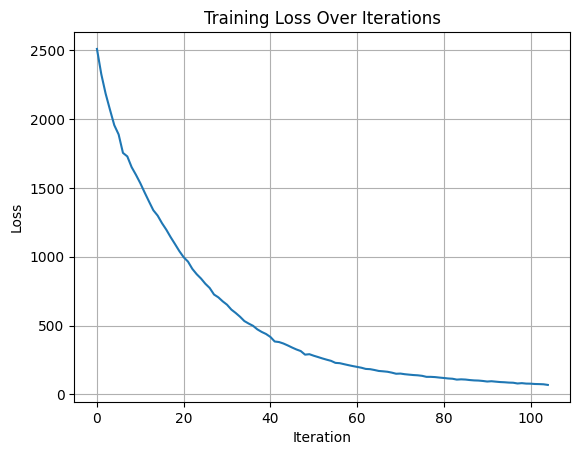

In [ ]:
import torch
from torch import nn
import pandas as pd
import random
import matplotlib.pyplot as plt

data_path = "/content/drive/MyDrive/data/malayalam_gender_profession_sentences.csv"
data = pd.read_csv(data_path)
data.rename(columns={
    'Male Sentence': 'male_sentence',
    'Female Sentence': 'female_sentence'
}, inplace=True)

male_sentences = data['male_sentence'].tolist()
female_sentences = data['female_sentence'].tolist()

model_name = "/content/drive/MyDrive/CAGD_LLM/BERT_Adversarially__Model"
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)

def cosine_similarity(a, b, eps=1e-8):
    a = nn.functional.normalize(a, dim=1, eps=eps)
    b = nn.functional.normalize(b, dim=1, eps=eps)
    return (a * b).sum(dim=1)

class GenderContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def forward(self, h_x, h_xg, h_others):
        pos_sim = cosine_similarity(h_x, h_xg)
        all_sim = torch.matmul(h_x, h_others.T) / self.temperature
        all_log_exp = torch.logsumexp(all_sim, dim=1)
        loss = -torch.mean(pos_sim / self.temperature - all_log_exp)
        return loss

# Encode sentences
def encode_sentences(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    outputs = encoder(**inputs)
    return outputs.last_hidden_state[:, 0, :]

def train_step(male_batch, female_batch, other_batch, loss_fn, optimizer):
    h_x = encode_sentences(male_batch)
    h_xg = encode_sentences(female_batch)
    h_others = encode_sentences(other_batch)

    loss = loss_fn(h_x, h_xg, h_others)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def create_batches(male_sentences, female_sentences, batch_size=32):
    indices = list(range(len(male_sentences)))
    random.shuffle(indices)
    for i in range(0, len(male_sentences), batch_size):
        batch_indices = indices[i:i + batch_size]
        male_batch = [male_sentences[idx] for idx in batch_indices]
        female_batch = [female_sentences[idx] for idx in batch_indices]
        other_batch = random.sample(
            [sent for idx, sent in enumerate(male_sentences) if idx not in batch_indices],
            len(batch_indices)
        )
        yield male_batch, female_batch, other_batch

loss_fn = GenderContrastiveLoss(temperature=0.1)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-6)

loss_values = []

for epoch in range(15):
    for male_batch, female_batch, other_batch in create_batches(male_sentences, female_sentences):
        loss = train_step(male_batch, female_batch, other_batch, loss_fn, optimizer)
        loss_values.append(loss)
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
model = encoder
model_save_path = "/content/drive/MyDrive/CAGD_LLM/2CAGD_BERT"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.grid(True)
plt.show()


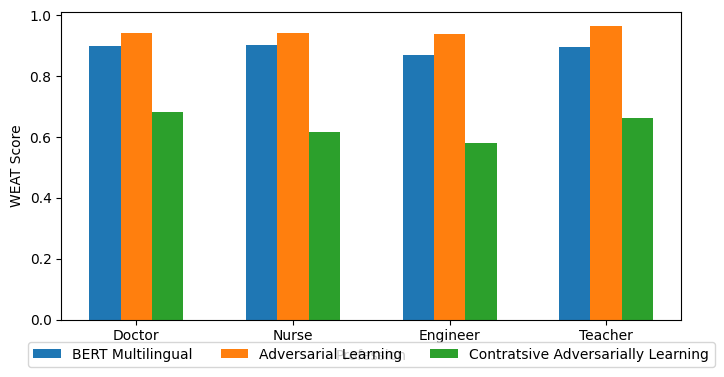

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

def get_embedding(model, tokenizer, word):
    tokens = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

def weat_score(model, tokenizer, target_words, attribute_words):
    target_embeddings = [get_embedding(model, tokenizer, word) for word in target_words]
    attribute_embeddings = [get_embedding(model, tokenizer, word) for word in attribute_words]

    mean_target = np.mean(target_embeddings, axis=0)
    mean_attribute = np.mean(attribute_embeddings, axis=0)
    return np.dot(mean_target, mean_attribute) / (np.linalg.norm(mean_target) * np.linalg.norm(mean_attribute))

def plot_weat_scores(models, model_names, professions, pronouns):
    scores = []
    for model_path in models:
        model = AutoModel.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        score = [weat_score(model, tokenizer, [profession], pronouns) for profession in professions]
        scores.append(score)

    bar_width = 0.2
    x = np.arange(len(professions))

    plt.figure(figsize=(8, 4))
    for i, (score, name) in enumerate(zip(scores, model_names)):
        plt.bar(x + i * bar_width, score, width=bar_width, label=name)

    plt.xticks(x + bar_width, ["Doctor", "Nurse", "Engineer", "Teacher"])
    plt.xlabel("Profession")
    plt.ylabel("WEAT Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.show()

# Define inputs
professions = [ "ബേക്കർ", "നഴ്സ്","എഞ്ചിനീയർ", "അധ്യാപകൻ"]
pronouns = ["അവൻ", "അവൾ", "അവർ"]
models = ["bert-base-multilingual-cased", "/content/drive/MyDrive/CAGD_LLM/BERT_Adversarially__Model", "/content/drive/MyDrive/CAGD_LLM/2CAGD_BERT"]
model_names = ["BERT Multilingual", "Adversarial Learning", "Contratsive Adversarially Learning"]

# Plot WEAT scores
plot_weat_scores(models, model_names, professions, pronouns)


In [ ]:
import torch
from transformers import AutoModel, AutoConfig

# Load the multilingual BERT model
model_name = "bert-base-multilingual-cased"
model = AutoModel.from_pretrained(model_name)

# Get model configuration
config = AutoConfig.from_pretrained(model_name)

# Print model architecture details
print("📌 Model Architecture Details")
print(f"Model Name: {model_name}")
print(f"Number of Layers: {config.num_hidden_layers}")
print(f"Hidden Size: {config.hidden_size}")
print(f"Number of Attention Heads: {config.num_attention_heads}")
print(f"Intermediate Layer Size: {config.intermediate_size}")
print(f"Dropout Rate: {config.hidden_dropout_prob}")
print(f"Max Position Embeddings: {config.max_position_embeddings}")

# Print the full model architecture
print("\n📌 Model Full Architecture:")
print(model)


📌 Model Architecture Details
Model Name: bert-base-multilingual-cased
Number of Layers: 12
Hidden Size: 768
Number of Attention Heads: 12
Intermediate Layer Size: 3072
Dropout Rate: 0.1
Max Position Embeddings: 512

📌 Model Full Architecture:
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
        

In [ ]:
import torch
from transformers import BertModel

# Load all three models
model_paths = [
    "bert-base-multilingual-cased",
    "/content/drive/MyDrive/CAGD_LLM/BERT_Adversarially__Model",
    "/content/drive/MyDrive/CAGD_LLM/2CAGD_BERT"
]
model_names = ["BERT Multilingual", "Adversarial Learning", "Contrastive Adversarial Learning"]

# Load models
models = [BertModel.from_pretrained(path) for path in model_paths]

# Compare weights layer by layer
for layer in range(12):  # BERT-base has 12 layers
    original_params = models[0].encoder.layer[layer].state_dict()
    adv_params = models[1].encoder.layer[layer].state_dict()
    cagd_params = models[2].encoder.layer[layer].state_dict()

    # Compute L2 norm difference between original and adversarial model
    adv_diff = sum((original_params[k] - adv_params[k]).norm().item() for k in original_params)
    # Compute L2 norm difference between original and CAGD model
    cagd_diff = sum((original_params[k] - cagd_params[k]).norm().item() for k in original_params)

    print(f"Layer {layer+1}: Adversarial Change = {adv_diff:.4f}, CAGD Change = {cagd_diff:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Layer 1: Adversarial Change = 0.2179, CAGD Change = 0.3843
Layer 2: Adversarial Change = 0.2254, CAGD Change = 0.3880
Layer 3: Adversarial Change = 0.2302, CAGD Change = 0.3815
Layer 4: Adversarial Change = 0.2321, CAGD Change = 0.3739
Layer 5: Adversarial Change = 0.2426, CAGD Change = 0.3900
Layer 6: Adversarial Change = 0.2517, CAGD Change = 0.3865
Layer 7: Adversarial Change = 0.2599, CAGD Change = 0.4139
Layer 8: Adversarial Change = 0.2641, CAGD Change = 0.4190
Layer 9: Adversarial Change = 0.2672, CAGD Change = 0.4251
Layer 10: Adversarial Change = 0.2737, CAGD Change = 0.4329
Layer 11: Adversarial Change = 0.2678, CAGD Change = 0.4564
Layer 12: Adversarial Change = 0.2614, CAGD Change = 0.4945


In [ ]:

import torch
from transformers import BertModel, BertTokenizer

# Paths to your models
model_paths = {
    "Original BERT": "bert-base-multilingual-cased",
    "Adversarial BERT": "/content/drive/MyDrive/CAGD_LLM/BERT_Adversarially__Model",
    "CAGD BERT": "/content/drive/MyDrive/CAGD_LLM/2CAGD_BERT"
}

# Load all models
models = {name: BertModel.from_pretrained(path) for name, path in model_paths.items()}

# Step 1: Identify which layers were frozen
print("\n🔍 Checking Frozen Layers in CAGD Model:")
for name, param in models["CAGD BERT"].named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Function to compute weight differences
def compute_layer_diff(model1, model2, layer_num):
    """
    Computes L2 norm difference between two model layers
    """
    layer1 = model1.encoder.layer[layer_num].state_dict()
    layer2 = model2.encoder.layer[layer_num].state_dict()

    return sum((layer1[k] - layer2[k]).norm().item() for k in layer1)

# Step 2: Compare weight changes across models
print("\n📊 Layer-wise Weight Change Comparison:")
for i in range(12):  # BERT has 12 layers
    adv_diff = compute_layer_diff(models["Original BERT"], models["Adversarial BERT"], i)
    cagd_diff = compute_layer_diff(models["Original BERT"], models["CAGD BERT"], i)
    print(f"Layer {i+1}: Adv Change = {adv_diff:.4f}, CAGD Change = {cagd_diff:.4f}")

# Step 3: Check bias reduction per layer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def get_layerwise_embedding(model, sentence, layer):
    tokens = tokenizer(sentence, return_tensors="pt")
    outputs = model(**tokens, output_hidden_states=True)
    return outputs.hidden_states[layer].mean(dim=1)  # Get layer-wise sentence embedding

# Example Male & Female Sentences
sentence_male = "അദ്ദേഹം ഒരു ഡോക്ടറാണ്."  # "He is a doctor."
sentence_female = "അവൾ ഒരു ഡോക്ടറാണ്."  # "She is a doctor."

print("\n📉 Layer-wise Gender Bias (Cosine Similarity):")
for i in range(1, 13):  # BERT has 12 layers
    emb_male = get_layerwise_embedding(models["CAGD BERT"], sentence_male, i)
    emb_female = get_layerwise_embedding(models["CAGD BERT"], sentence_female, i)

    cosine_sim = torch.nn.functional.cosine_similarity(emb_male, emb_female).item()
    print(f"Layer {i}: Gender Cosine Similarity = {cosine_sim:.4f}")



🔍 Checking Frozen Layers in CAGD Model:
embeddings.word_embeddings.weight: Trainable
embeddings.position_embeddings.weight: Trainable
embeddings.token_type_embeddings.weight: Trainable
embeddings.LayerNorm.weight: Trainable
embeddings.LayerNorm.bias: Trainable
encoder.layer.0.attention.self.query.weight: Trainable
encoder.layer.0.attention.self.query.bias: Trainable
encoder.layer.0.attention.self.key.weight: Trainable
encoder.layer.0.attention.self.key.bias: Trainable
encoder.layer.0.attention.self.value.weight: Trainable
encoder.layer.0.attention.self.value.bias: Trainable
encoder.layer.0.attention.output.dense.weight: Trainable
encoder.layer.0.attention.output.dense.bias: Trainable
encoder.layer.0.attention.output.LayerNorm.weight: Trainable
encoder.layer.0.attention.output.LayerNorm.bias: Trainable
encoder.layer.0.intermediate.dense.weight: Trainable
encoder.layer.0.intermediate.dense.bias: Trainable
encoder.layer.0.output.dense.weight: Trainable
encoder.layer.0.output.dense.bias: 

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


📉 Layer-wise Gender Bias (Cosine Similarity):
Layer 1: Gender Cosine Similarity = 0.9437
Layer 2: Gender Cosine Similarity = 0.9452
Layer 3: Gender Cosine Similarity = 0.9661
Layer 4: Gender Cosine Similarity = 0.9703
Layer 5: Gender Cosine Similarity = 0.9726
Layer 6: Gender Cosine Similarity = 0.9644
Layer 7: Gender Cosine Similarity = 0.9480
Layer 8: Gender Cosine Similarity = 0.9490
Layer 9: Gender Cosine Similarity = 0.9735
Layer 10: Gender Cosine Similarity = 0.9865
Layer 11: Gender Cosine Similarity = 0.9917
Layer 12: Gender Cosine Similarity = 0.8238


In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/content/drive/MyDrive/data/WINOGENDER_malayalam_.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Display basic info about the dataset
print("Dataset Information:")
print(df.info())

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check the unique values per column (for categorical data analysis)
print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# Generate sample input for a prompt (modify based on your dataset structure)
if not df.empty:
    sample_row = df.iloc[0].to_dict()
    prompt_input = ", ".join([f"{key}: {value}" for key, value in sample_row.items()])
    print("\nGenerated Prompt Input Example:")
    print(f"Use this data: {prompt_input}")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentence ID  612 non-null    object
 1   Sentence     612 non-null    object
dtypes: object(2)
memory usage: 9.7+ KB
None

First 5 rows of the dataset:
                     Sentence ID  \
0     ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.male   
1   ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.female   
2  ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.neutral   
3     ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.male   
4   ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.female   

                                            Sentence  
0  ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ കാഷ് നൽകാമെ...  
1  ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ കാഷ് നൽകാമെ...  
2  ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവർ കാഷ് നൽകാമെ...  
3  ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ അറ്റകുറ്റപ്...  
4  ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ അറ്റകുറ്റപ്...  

Missing values in each column:
Sentence ID    0
Sentence       0
dtype: int64

Unique va

## Data loading

### Subtask:
Load the sentences from the "winogen-mal_professions_sentences2.csv" file into a pandas DataFrame.


**Reasoning**:
Load the dataframe and inspect it to ensure the sentences are correctly loaded.



In [ ]:
import pandas as pd

try:
    df = pd.read_csv('winogen-mal_professions_sentences2.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'winogen-mal_professions_sentences2.csv' not found. Please provide the correct file path.")
    df = None
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,Sentence ID,Sentence
0,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ കാഷ് നൽകാമെ..."
1,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ കാഷ് നൽകാമെ..."
2,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.neutral,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവർ കാഷ് നൽകാമെ..."
3,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ അറ്റകുറ്റപ്..."
4,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ അറ്റകുറ്റപ്..."


## Data preparation

### Subtask:
Preprocess the sentences in the 'Sentence' column of the DataFrame `df`.


**Reasoning**:
Preprocess the sentences by converting to lowercase, removing punctuation, handling special characters (by removing them in this case), and optionally removing stop words (skipped here as no Malayalam stop word list is provided).



In [ ]:
import re

def preprocess_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Remove special characters (simplified approach)
    sentence = re.sub(r'[^\x00-\x7F]+', '', sentence)
    return sentence

df['preprocessed_sentence'] = df['Sentence'].apply(preprocess_sentence)
display(df.head())

,Sentence ID,Sentence,preprocessed_sentence
0,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ കാഷ് നൽകാമെ...",
1,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ കാഷ് നൽകാമെ...",
2,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.neutral,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവർ കാഷ് നൽകാമെ...",
3,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ അറ്റകുറ്റപ്...",
4,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ അറ്റകുറ്റപ്...",


## Feature engineering

### Subtask:
Generate sentence embeddings for the preprocessed sentences.


**Reasoning**:
Install sentence-transformers and generate sentence embeddings using the 'all-mpnet-base-v2' model. This model is known for its good performance and multilingual capabilities.



In [ ]:
try:
    from sentence_transformers import SentenceTransformer, util
    model = SentenceTransformer('all-mpnet-base-v2')
    df['sentence_embedding'] = df['preprocessed_sentence'].apply(lambda x: model.encode(x))
    print(f"Embedding shape: {df['sentence_embedding'].iloc[0].shape}")
    display(df.head())
except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Error: User secrets cannot be accessed in agent mode. Learn more at https://research.google.com/colaboratory/faq.html#data-science-agent.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: (768,)


,Sentence ID,Sentence,preprocessed_sentence,sentence_embedding
0,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ കാഷ് നൽകാമെ...",,"[-0.012503399, 0.06143877, -0.006734532, 0.025..."
1,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ കാഷ് നൽകാമെ...",,"[-0.012503399, 0.06143877, -0.006734532, 0.025..."
2,ടെക്നീഷ്യൻ.കസ്റ്റമർ.1.neutral,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവർ കാഷ് നൽകാമെ...",,"[-0.012503399, 0.06143877, -0.006734532, 0.025..."
3,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.male,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൻ അറ്റകുറ്റപ്...",,"[-0.012503399, 0.06143877, -0.006734532, 0.025..."
4,ടെക്നീഷ്യൻ.കസ്റ്റമർ.0.female,"ടെക്നീഷ്യൻ കസ്റ്റമർോട് പറഞ്ഞു, അവൾ അറ്റകുറ്റപ്...",,"[-0.012503399, 0.06143877, -0.006734532, 0.025..."
